In [296]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [297]:
# Load the CSV file
teraterm_path = "C:/Users/hylth/AppData/Local/teraterm5/"
file_name = "LooseGripZTaps.csv"
data = pd.read_csv(teraterm_path + file_name)

# Assign column names.
data.columns = ['t', 'ax', 'ay', 'az', 'gx', 'gy', 'gz']

data['t'] = data['t'] / 1_000_000
data[['ax', 'ay', 'az']] = data[['ax', 'ay', 'az']] / 2048
data[['gx', 'gy', 'gz']] = data[['gx', 'gy', 'gz']] / 65.5

# Display the first few rows of the dataset
print(data.head())


          t        ax        ay        az          gx          gy          gz
0  1.003696  0.063965  0.049316  0.995117 -500.274809 -500.274809 -500.274809
1  1.003949  0.063477  0.061523  1.099609 -500.274809 -500.274809 -500.274809
2  1.004201  0.063477  0.061523  1.099609 -500.274809 -500.274809 -500.274809
3  1.004454  0.065430  0.050781  1.060547 -500.274809 -500.274809 -500.274809
4  1.004707  0.065918  0.060547  1.095215 -500.274809 -500.274809 -500.274809


In [298]:
# Define a threshold for contact detection (example: acceleration > 10)
threshold = 2

# Create labels based on the threshold
data['contact'] = ((data['ax']**2 + data['ay']**2 + data['az']**2)**0.5 > threshold).astype(int)

# Display the updated dataset
print(data.head())

          t        ax        ay        az          gx          gy          gz  \
0  1.003696  0.063965  0.049316  0.995117 -500.274809 -500.274809 -500.274809   
1  1.003949  0.063477  0.061523  1.099609 -500.274809 -500.274809 -500.274809   
2  1.004201  0.063477  0.061523  1.099609 -500.274809 -500.274809 -500.274809   
3  1.004454  0.065430  0.050781  1.060547 -500.274809 -500.274809 -500.274809   
4  1.004707  0.065918  0.060547  1.095215 -500.274809 -500.274809 -500.274809   

   contact  
0        0  
1        0  
2        0  
3        0  
4        0  


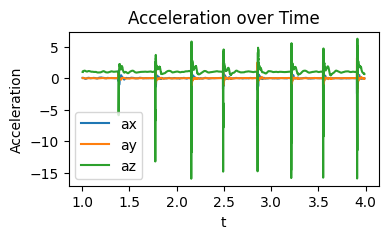

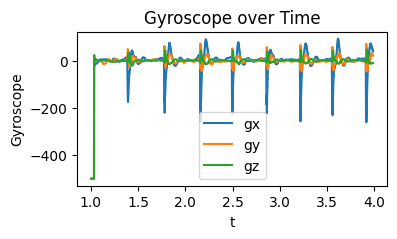

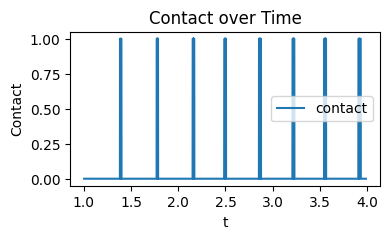

In [299]:
import matplotlib.pyplot as plt

# Plot ax, ay, az over time
plt.figure(figsize=(4, 2))
plt.plot(data['t'], data['ax'], label='ax')
plt.plot(data['t'], data['ay'], label='ay')
plt.plot(data['t'], data['az'], label='az')
plt.xlabel('t')
plt.ylabel('Acceleration')
plt.title('Acceleration over Time')
plt.legend()
plt.show()

# Plot gx, gy, gz over time
plt.figure(figsize=(4, 2))
plt.plot(data['t'], data['gx'], label='gx')
plt.plot(data['t'], data['gy'], label='gy')
plt.plot(data['t'], data['gz'], label='gz')
plt.xlabel('t')
plt.ylabel('Gyroscope')
plt.title('Gyroscope over Time')
plt.legend()
plt.show()

# Plot contact over time
plt.figure(figsize=(4, 2))
plt.plot(data['t'], data['contact'], label='contact')
plt.xlabel('t')
plt.ylabel('Contact')
plt.title('Contact over Time')
plt.legend()
plt.show()

In [300]:
# Separate features and label
# X contains the sensor readings: acceleration (ax, ay, az) and gyroscope (gx, gy, gz)
# y contains the binary contact label (0: no contact, 1: contact)
X = data[['ax', 'ay', 'az']].values
y = data['contact'].values

# Split the data into training and testing sets
# 80% for training, 20% for testing, random_state ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [307]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, output_size)
        self.sigmoid = nn.Sigmoid() # Activation for binary classification

    def forward(self, x):
        x = self.sigmoid(self.fc1(x))  # Sigmoid activation for output
        return x

In [308]:
# Convert to PyTorch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

In [309]:
# Model parameters
input_size = X_train.shape[1]  # Number of features (6: ax, ay, az, gx, gy, gz)
hidden_size = 16  # Number of neurons in the hidden layers
output_size = 1  # Binary classification (contact or no contact)

# Initialize the model
model = SimpleNN(input_size, hidden_size, output_size)
model = model.to(device)

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

In [310]:
# Training loop
epoch = 0
last_loss = float('inf')
while True:
    epoch += 1

    model.train()  # Set the model to training mode

    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Early stopping: break if loss increases compared to previous epoch
    if loss.item() > last_loss:
        print(f"Early stopping at epoch {epoch+1} due to increasing loss. {loss.item()} > {last_loss}")
        break
    last_loss = loss.item()

    # Print loss every 100 epochs
    if (epoch) % 1000 == 0:
        print(f'Epoch [{epoch}], Loss: {loss.item():.8f}')

Epoch [1000], Loss: 0.35009444
Epoch [2000], Loss: 0.21779886
Epoch [3000], Loss: 0.15912731
Epoch [4000], Loss: 0.13126396
Epoch [5000], Loss: 0.11798533
Epoch [6000], Loss: 0.11209136
Epoch [7000], Loss: 0.10990158
Epoch [8000], Loss: 0.10933099
Epoch [9000], Loss: 0.10925427
Early stopping at epoch 9260 due to increasing loss. 0.10925213247537613 > 0.10925212502479553


In [311]:
# Evaluate the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_class = (y_pred > 0.5).float()  # Convert probabilities to binary predictions
    accuracy = (y_pred_class == y_test_tensor).sum().item() / y_test_tensor.size(0)
    print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9720


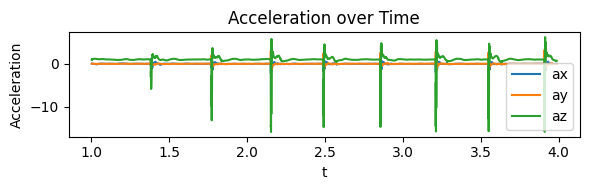

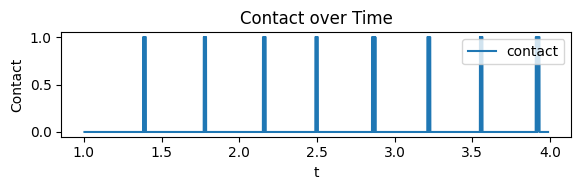

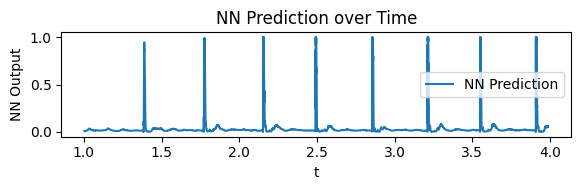

In [312]:
import matplotlib.pyplot as plt

# Plot ax, ay, az over time
plt.figure(figsize=(6, 2))
plt.plot(data['t'], data['ax'], label='ax')
plt.plot(data['t'], data['ay'], label='ay')
plt.plot(data['t'], data['az'], label='az')
plt.xlabel('t')
plt.ylabel('Acceleration')
plt.title('Acceleration over Time')
plt.legend()
plt.tight_layout()
plt.show()

# Plot contact over time
plt.figure(figsize=(6, 2))
plt.plot(data['t'], data['contact'], label='contact')
plt.xlabel('t')
plt.ylabel('Contact')
plt.title('Contact over Time')
plt.legend()
plt.tight_layout()
plt.show()

# Get NN predictions for all data points
model.eval()
with torch.no_grad():
    X_all = scaler.transform(data[['ax', 'ay', 'az']].values)
    X_all_tensor = torch.tensor(X_all, dtype=torch.float32).to(device)
    y_all_pred = model(X_all_tensor).cpu().numpy().flatten()

# Plot NN predictions over time
plt.figure(figsize=(6, 2))
plt.plot(data['t'], y_all_pred, label='NN Prediction')
plt.xlabel('t')
plt.ylabel('NN Output')
plt.title('NN Prediction over Time')
plt.legend()
plt.tight_layout()
plt.show()